In [14]:
import pandas as pd
import joblib
import shap
import numpy as np
import ipywidgets as widgets
from ipywidgets import VBox, Checkbox, IntProgress
from IPython.display import display, HTML, clear_output
import warnings
import plotly.express as px
import os
import matplotlib.pyplot as plt
import sqlite3

In [15]:
conn = sqlite3.connect('test_data/lw.db')

In [16]:
# Make the font the same as latex 
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('xtick', labelsize=16)
rc('ytick', labelsize=16)
rc('axes', labelsize=18)
rc('axes', titlesize=18)
rc('legend', fontsize=16)

In [17]:
# Support plotly in binder
if "BINDER_SERVICE_HOST" in os.environ:
    import plotly.io as pio
    pio.renderers.default='iframe'

In [18]:
warnings.filterwarnings('ignore')
plot_matplotlib = True

In [19]:
shap.initjs()

In [20]:
df = pd.read_csv("test_data/new leaky wave/S11_Data_combined_w_extra.csv")
# df_all = pd.read_pickle("all_predictions.pkl")

In [26]:
working_geometries = pd.DataFrame()
s11_val = 0
freq_val = 0
show_best_only = True
only_simulated = False

# Filter working_geometries by best
def filter_by_best(filtered_geometries):
    best_s11 = 0
    freq_min, freq_max = freq_val

    # Get rows only in this frequency range
    geos_within_freq = filtered_geometries[(filtered_geometries['Freq [GHz]'] > freq_min) & (filtered_geometries['Freq [GHz]'] < freq_max)]
    
    # Separate out geometries into groups 
    grouped_df = geos_within_freq.groupby(["Geometry Name"])

    # Get the best top s11 out of all of the geometries 
    best_s11 = grouped_df['prediction'].max().min()

    # For each geometry, get the highest possible s11 value. Then, take the lowest of all of the top s11 values
    group_mask = grouped_df['prediction'].transform(lambda x: x.max() == best_s11).astype(bool)
    geos_meeting_criteria = geos_within_freq.loc[group_mask].reset_index(drop=True)
    unique_geos_meeting_criteria = geos_meeting_criteria['Geometry Name'].unique().tolist()

    # Return all rows for each unique geometry with lowest top prediction between range
    return filtered_geometries[filtered_geometries['Geometry Name'].isin(unique_geos_meeting_criteria)]

# Initialize progress bar
pbar = IntProgress(min=0, max=5)

# Display progress bar
loading_out = widgets.Output()
@loading_out.capture()
def loading_message():
    clear_output()
    display(HTML("<h3>Loading...</h3>"))
    display(pbar)

# Update progress bar when step is true, or reset when false 
def update_pbar(step=False):
    global pbar
    if step:
        pbar.value += 1
    else:
        pbar.value = 0

out = widgets.Output()
@out.capture()
def print_dimensions():
    clear_output()

    if not working_geometries.empty:
        filtered_geometries = working_geometries.copy()

        if only_simulated:
            filtered_geometries = filtered_geometries[filtered_geometries['source_simulated'] == 1]

        if show_best_only:
            filtered_geometries = filter_by_best(filtered_geometries)
        update_pbar(1)

        freq_min, freq_max = freq_val
        unique_geometries = filtered_geometries['Geometry Name'].unique()
        display(HTML(f"<h2>{unique_geometries.shape[0]} Geometries</h2>"))

        # Begin setting up matplotlib figure
        # if plot_matplotlib:
        #     plt.figure(figsize=(6,4))

        # Create & display plotly figure
        fig = px.line(filtered_geometries, x="Freq [GHz]", y="prediction", title='Performance vs Frequency for Geometries', color="Geometry Name")
        fig.add_hline(y=s11_val, line_dash="dash", line_color="blue")
        fig.add_vline(x=freq_min, line_dash="dash", line_color="green")
        fig.add_vline(x=freq_max, line_dash="dash", line_color="green")
        display(fig)

        update_pbar(1)

        # Plot each geometry for matplotlib
        if plot_matplotlib:
            for geometry_name in unique_geometries:
                rows = filtered_geometries[filtered_geometries['Geometry Name'] == geometry_name]

                # Plot line for matplotlib 
                plt.plot(rows['Freq [GHz]'], rows['prediction'], label=geometry_name)

        # Display all geometries in table 
        filtered_geometries['Source'] = filtered_geometries.apply(lambda x: "Simulated" if x['source_simulated'] else "Predicted", axis=1) # 1 if simulated, 0 if predicted
        filtered_geometries.drop(columns=['Freq [GHz]', 'prediction', 'source_simulated'], inplace=True)
        filtered_geometries.drop_duplicates(inplace=True)
        display(HTML(filtered_geometries.to_html(index=False)))

        # Finish setting up matplotlib figure 
        if plot_matplotlib:
            plt.xlabel("Freq [GHz]")
            plt.ylabel("Prediction")
            legend_disp = unique_geometries[:7].tolist()
            if len(unique_geometries) > 7:
                legend_disp += ["..."]
            plt.legend(legend_disp, loc="lower right")
            plt.axhline(y=s11_val, color='b', linestyle='--')
            plt.axvline(x=freq_min, color='g', linestyle='--')
            plt.axvline(x=freq_max, color='g', linestyle='--')
            plt.savefig(f"{'-'.join([str(geo) for geo in legend_disp])}.svg", format="svg")
    else:
        display(HTML("<h2>No results found</h2>"))

# def print_shap(dimensions_for_prediction):
#     explainer = shap.TreeExplainer(model.named_steps['model'])
#     shap_values = explainer(dimensions_for_prediction)

#     display(HTML("<h2>Shap Explanation</h2>"))
#     shap.plots.waterfall(shap_values[0], max_display=14)

In [27]:
def print_prediction():
    global working_geometries
    loading_message()
    update_pbar(0)
    update_pbar(1)

    freq_min, freq_max = freq_val

    # SQL query
    # First, select all unique geometries where all s11 predictions are below desired s11 between freq min and max (inner)
    # Second, find all frequencies for the unique geometries (outer) 
    base_sql_query = """
        select * from geometries
        where ("cpw_in [mm]", "feed_l [mm]", "patch_l [mm]", "Feed_W [mm]", "ground_w [mm]", "patch_ground_w [mm]", "patch_w [mm]") in (
            select "cpw_in [mm]", "feed_l [mm]", "patch_l [mm]", "Feed_W [mm]", "ground_w [mm]", "patch_ground_w [mm]", "patch_w [mm]"
            from geometries
            where "Freq [GHz]" > ?
            and "Freq [GHz]" < ?
            group by "cpw_in [mm]", "feed_l [mm]", "patch_l [mm]", "Feed_W [mm]", "ground_w [mm]", "patch_ground_w [mm]", "patch_w [mm]"
            having max(prediction) < ?
        )
    """

    # Pull results from sqlite file 
    working_geometries = pd.read_sql_query(base_sql_query,
        con=conn,
        params=(freq_min, freq_max, s11_val, )
    )
    update_pbar(1)

    if not working_geometries.empty:        
        geo_params = working_geometries.columns.tolist()[:-3]
        working_geometries['Geometry Name'] = working_geometries.groupby(geo_params).ngroup() # Set the name for each group of geometry 

        # Get df of unique geometries within filter, keeping the freq column with the highest freq of each
        working_geometries = working_geometries.drop_duplicates(subset=working_geometries.columns[:-2], keep='first')
        update_pbar(1)

    # Print results 
    print_dimensions()
        # print('PRINT SHAP')
        # geos_to_pass = working_geometries.copy()
        # geos_to_pass.drop(columns=['Geometry Name', 'prediction'], inplace=True)
        # print_shap(geos_to_pass.iloc[0]) # TODO FIX ME NOT WORKING


In [28]:
s11_min, s11_max = conn.execute("select min(prediction), max(prediction) from geometries").fetchone()

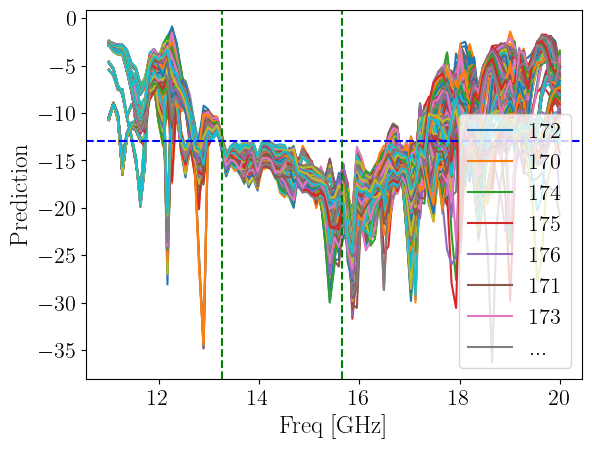

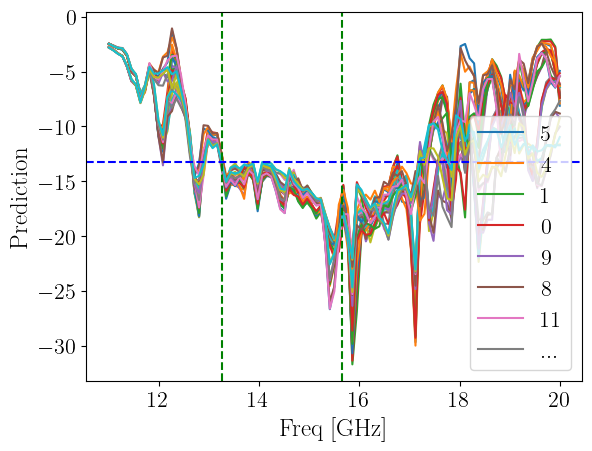

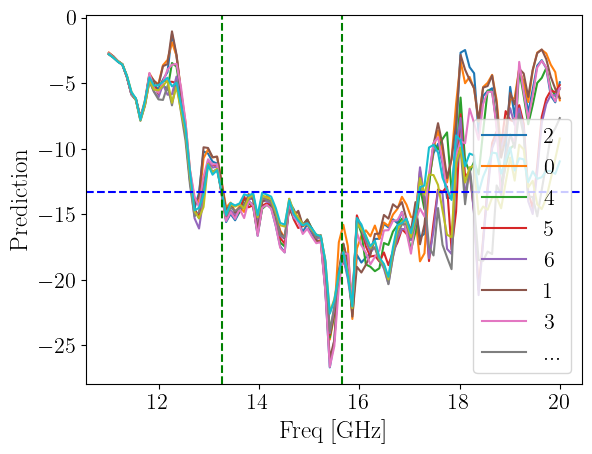

In [29]:
s11_input = widgets.BoundedFloatText(value=-10, min=s11_min, max=s11_max, step=0.05, description="S11:")
freq_input = widgets.FloatRangeSlider(min=df['Freq [GHz]'].min(), max=df['Freq [GHz]'].max(), step=0.01, description="Frequency Range:")

def on_button_clicked(b):
    global s11_val, freq_val
    s11_val = s11_input.value
    freq_val = freq_input.value
    print_prediction()

def show_best_function(checkbox_val):
    global show_best_only
    show_best_only = checkbox_val['new']
    print_dimensions()

def only_include_simulated(checkbox_val):
    global only_simulated
    only_simulated = checkbox_val['new']
    print_dimensions()

go_button = widgets.Button(description="Run")
go_button.on_click(on_button_clicked)

show_best_checkbox = Checkbox(True, description='Only Show Best')
show_best_checkbox.observe(show_best_function, names=['value'])

show_simulated_checkbox = Checkbox(False, description='Only Show Simulated')
show_simulated_checkbox.observe(only_include_simulated, names=['value'])

In [30]:
display(VBox([s11_input, freq_input, go_button, show_best_checkbox, show_simulated_checkbox, loading_out, out]))